In [13]:
from ioncast import *
from torch.utils.data import DataLoader
import datetime
from ioncast import IonCastGNN

device = device = torch.device('cuda:0') # 'cpu'

In [14]:
# Create sequence dataset
gim_dir = "/home/jupyter/data/jpld/webdataset"
omni_dir = "/home/jupyter/data/omniweb/cleaned"
celestrak_file = "/home/jupyter/data/celestrak/kp_ap_processed_timeseries.csv"

# Create sequence dataset
# gim_dir = "/mnt/disks/disk-main-data-1/data/jpld/webdataset"
# omni_dir = "/mnt/disks/disk-main-data-1/data/omniweb/cleaned"
# celestrak_file = "/mnt/disks/disk-main-data-1/data/celestrak/kp_ap_processed_timeseries.csv"

date_start = datetime.datetime(2018, 1, 1, 0, 0, 0)
date_end = datetime.datetime(2018, 1, 2, 0, 0, 0)
delta_minutes = 15

gim_dataset = JPLDGIMDataset(
    data_dir=gim_dir,
    date_start=date_start,
    date_end=date_end,
)

omni_dataset = OMNIDataset(
    file_dir=omni_dir,
    date_start=date_start,
    date_end=date_end,
)

celestrak_dataset = CelestrakDataset(
    file_name=celestrak_file,
    date_start=date_start,
    date_end=date_end,
)

sequence_dataset = Sequences([gim_dataset, omni_dataset, celestrak_dataset], delta_minutes=delta_minutes, sequence_length=3)
# sequence_dataset = Sequences([gim_dataset], delta_minutes=15, sequence_length=20)


JPLD
Directory  : /home/jupyter/data/jpld/webdataset
Loading tar files index from cache: /home/jupyter/data/jpld/webdataset/tar_files_index
Start date : 2018-01-01 00:00:00
End date   : 2018-01-02 00:00:00
Delta      : 15 minutes
Loading dates from cache: /home/jupyter/data/jpld/webdataset/dates_index_2018-01-01T00:00:00_2018-01-02T00:00:00
TEC maps total    : 96
TEC maps available: 96
TEC maps dropped  : 0

OMNIWeb dataset
File                 : /home/jupyter/data/omniweb/cleaned/omni_5min_full_cleaned.csv
Rows                 : 2,103,840
Delta minutes        : 15
Normalize            : True
Rewind minutes       : 50
column:['B_mag', 'Bx_GSE', 'By_GSM', 'Bz_GSM', 'RMS_B_scalar', 'RMS_B_vector', 'V_flow', 'Vx', 'Vy', 'Vz', 'Density', 'Temp', 'SYM_D', 'SYM_H', 'ASY_D', 'ASY_H']
2103840


/home/LinneaWolniewicz/2025-HL-Ionosphere/ioncast/datasets/base_datasets.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Datetime'] = pd.to_datetime(self.data['Datetime']) # this line wasnt present previously but is necessary if the col contains strings instead of pandas timestamps for the date.to_pydatetime() to run as expected


Start date           : 2018-01-01 00:00:00
End date             : 2018-01-02 00:00:00
Rows after processing: 228

Celestrak dataset
File                 : /home/jupyter/data/celestrak/kp_ap_processed_timeseries.csv
Rows                 : 198,320
Delta minutes        : 15
Normalize            : True
Rewind minutes       : 180
column:['Kp', 'Ap']
2379829
Start date           : 2018-01-01 00:00:00
End date             : 2018-01-02 00:00:00
Rows after processing: 97

Sequences
Start date              : 2018-01-01 00:00:00
End date                : 2018-01-02 00:00:00
Delta                   : 15 minutes
Sequence length         : 3
Sequence duration       : 45 minutes
Number of sequences     : 76
First sequence          : ['2018-01-01T00:00:00', '2018-01-01T00:15:00', '2018-01-01T00:30:00']
Last sequence           : ['2018-01-01T23:30:00', '2018-01-01T23:45:00', '2018-01-02T00:00:00']


## Test prediction without a dataloader

In [15]:
# forecast start is 1 hour before date end
date_forecast_start = date_end - datetime.timedelta(hours=1)

print('Evaluation from {} to {}'.format(date_start, date_end))
print('Forecast start date: {}'.format(date_forecast_start))
sequence_start = date_start
sequence_end = date_end
sequence_length = int((sequence_end - sequence_start).total_seconds() / 60 / delta_minutes)
print('Sequence length: {}'.format(sequence_length))
sequence = [sequence_start + datetime.timedelta(minutes=delta_minutes * i) for i in range(sequence_length)]

# find the index of the date_forecast_start in the list sequence
if date_forecast_start not in sequence:
    raise ValueError('date_forecast_start must be in the sequence')
sequence_forecast_start_index = sequence.index(date_forecast_start)
sequence_prediction_window = sequence_length - (sequence_forecast_start_index) # TODO: should this be sequence_length - (sequence_forecast_start_index + 1)

Evaluation from 2018-01-01 00:00:00 to 2018-01-02 00:00:00
Forecast start date: 2018-01-01 23:00:00
Sequence length: 96


In [16]:
sequence_data = sequence_dataset.get_sequence_data(sequence)
print(sequence_data)

# Stack features will output shape (B, T, C, H, W)
grid_nodes = stack_features(
    sequence_data, 
    n_img_datasets=1, 
)

grid_nodes = grid_nodes.to(device)
grid_nodes = grid_nodes.float() # Ensure the grid nodes are in float32 

# Check shapes: sequence_data and grid_nodes
print('Shape of sequence_data:', [len(data) for data in sequence_data])
print('Shape of grid_nodes:', grid_nodes.shape)
print(f'Device of grid_nodes: {grid_nodes.device}')
B, T, C, H, W = grid_nodes.shape

(tensor([[[[-1.4464, -1.4837, -1.4837,  ..., -1.4464, -1.4464, -1.4464],
          [-1.3752, -1.3752, -1.3752,  ..., -1.3412, -1.3412, -1.3752],
          [-1.2762, -1.2762, -1.2762,  ..., -1.2762, -1.2762, -1.2762],
          ...,
          [ 0.0463,  0.0561,  0.0561,  ...,  0.0463,  0.0463,  0.0463],
          [ 0.0162,  0.0162,  0.0162,  ...,  0.0060,  0.0060,  0.0162],
          [-0.0252, -0.0252, -0.0252,  ..., -0.0252, -0.0252, -0.0252]]],


        [[[-1.4103, -1.4103, -1.4103,  ..., -1.3752, -1.4103, -1.4103],
          [-1.3082, -1.3082, -1.3082,  ..., -1.3082, -1.3082, -1.3082],
          [-1.2450, -1.2450, -1.2450,  ..., -1.2450, -1.2450, -1.2450],
          ...,
          [ 0.0263,  0.0263,  0.0263,  ...,  0.0162,  0.0263,  0.0263],
          [-0.0252, -0.0147, -0.0147,  ..., -0.0252, -0.0252, -0.0252],
          [-0.0682, -0.0682, -0.0682,  ..., -0.0682, -0.0682, -0.0682]]],


        [[[-1.3752, -1.3752, -1.3752,  ..., -1.3752, -1.3752, -1.3752],
          [-1.3082, -1.30

In [18]:
model = IonCastGNN(mesh_level=1, input_res=(180, 360), input_dim_grid_nodes=T*C, output_dim_grid_nodes=C, device=device)
print(model.device)

prediction = model.predict(grid_nodes, prediction_window=sequence_prediction_window)
print(prediction.shape)

AttributeError: 'IonCastGNN' object has no attribute 'device'

## Test dataloader and passing through the model

In [3]:
# Batch into 5 using a DataLoader
dataloader = DataLoader(
    sequence_dataset,
    batch_size=1,
    shuffle=True,
)


In [4]:
from ioncast import stack_features

# Iterate through the DataLoader
for batch in dataloader:
    # Print timestamp and features
    print(f"Timestamps: {batch[-1]}")

    timestamps = batch[-1]
    jpld = batch[0]
    omni = batch[1]
    celestrak = batch[2]
    
    stacked_batch = stack_features(batch)
    B, T, C, H, W = stacked_batch.shape
    print(stacked_batch)  # Print the stacked features
    print(f"Batch shape: {B}, Time steps: {T}, Channels: {C}, Height: {H}, Width: {W}")
    print("JPLD 0, omni 1-16, celstrak 17-18, subsolar 19, sublunar 20, sin(tod) 21, cos(tod) 22, sin(doy) 23, cos(doy) 24")

    break

Timestamps: [('2016-07-04T23:45:00',), ('2016-07-05T00:00:00',)]
tensor([[[[[-0.5190, -0.5190, -0.5190,  ..., -0.5190, -0.5190, -0.5190],
           [-0.4869, -0.4869, -0.4869,  ..., -0.4869, -0.4869, -0.4869],
           [-0.4404, -0.4557, -0.4557,  ..., -0.4404, -0.4404, -0.4404],
           ...,
           [-2.6261, -2.6261, -2.6261,  ..., -2.6261, -2.6261, -2.6261],
           [-2.6261, -2.6261, -2.6261,  ..., -2.6261, -2.6261, -2.6261],
           [-2.6261, -2.6261, -2.6261,  ..., -2.6261, -2.6261, -2.6261]],

          [[-0.4181, -0.4181, -0.4181,  ..., -0.4181, -0.4181, -0.4181],
           [-0.4181, -0.4181, -0.4181,  ..., -0.4181, -0.4181, -0.4181],
           [-0.4181, -0.4181, -0.4181,  ..., -0.4181, -0.4181, -0.4181],
           ...,
           [-0.4181, -0.4181, -0.4181,  ..., -0.4181, -0.4181, -0.4181],
           [-0.4181, -0.4181, -0.4181,  ..., -0.4181, -0.4181, -0.4181],
           [-0.4181, -0.4181, -0.4181,  ..., -0.4181, -0.4181, -0.4181]],

          [[ 0.8231,  0

Test IonCastGNN

In [5]:
from ioncast import IonCastGNN
model = IonCastGNN(mesh_level=1, input_res=(360, 180), input_dim_grid_nodes=T*C, output_dim_grid_nodes=T*C)

print(stacked_batch.shape)
output = model(stacked_batch)
print(output.shape)  # Should be (B, T*C, H, W) where

torch.Size([1, 2, 25, 180, 360])
torch.Size([1, 50, 360, 180])


In [6]:
input_tensor = torch.rand(1, 2, 3, 180, 360) # (B, T, C, H, W)

model = IonCastGNN(mesh_level=1, input_res=(180, 360), input_dim_grid_nodes=6, output_dim_grid_nodes=6)

print(input_tensor.shape)
output = model(input_tensor)
print(output.shape) 

torch.Size([1, 2, 3, 180, 360])
torch.Size([1, 6, 180, 360])


Plot output of stacked features

IndexError: index 4 is out of bounds for dimension 1 with size 2

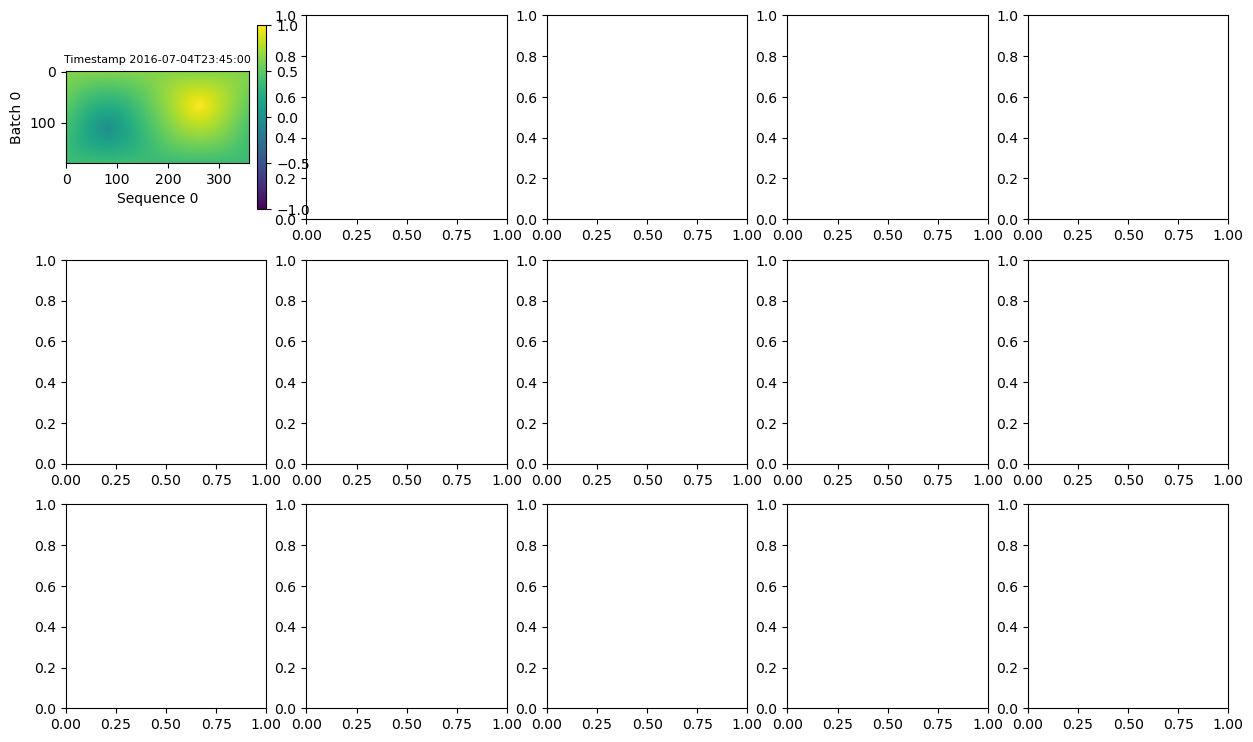

In [7]:
# Create a 3 x 5 subplot plotting the first feature (vTEC) of the stacked_batch
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i in range(3): # Batch
    # first_img = stacked_batch[i, 0, 0].cpu().numpy()  # First feature (vTEC)
    for j in range(5): # Sequence
        feature_idx = 19 # JPLD 0, omni 1-16, celstrak 17-18, subsolar 19, sublunar 20, sin(tod) 21, cos(tod) 22, sin(doy) 23, cos(doy) 24
        seq_idx = j*4

        axs[i, j].imshow(stacked_batch[i, seq_idx, feature_idx].cpu().numpy(), cmap='viridis', clim=(-1, 1))
        axs[i, j].set_title(f"Timestamp {timestamps[seq_idx][i]}", fontsize=8)
        axs[i, j].set_ylabel(f"Batch {i}")
        axs[i, j].set_xlabel(f"Sequence {seq_idx}")
        
        # add colorbar
        plt.colorbar(axs[i, j].images[0], ax=axs[i, j], orientation='vertical', fraction=0.046, pad=0.04)


plt.suptitle(f"feature idx {feature_idx}")
plt.tight_layout()
plt.show()

In [ ]:
np.cos(2*np.pi*(6*60 + 45)/(24*60))

np.float64(-0.19509032201612797)